In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
# from tools.GRU_AR_v8 import AR_RNN_GRU as AR_RNN
from tools.LSTM_AR_v2 import AR_RNN_LSTM as AR_RNN
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-18 09:43:50.417873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 09:43:50.418190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 09:43:50.498486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 09:43:50.498784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 09:43:50.499120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_060'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_060
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

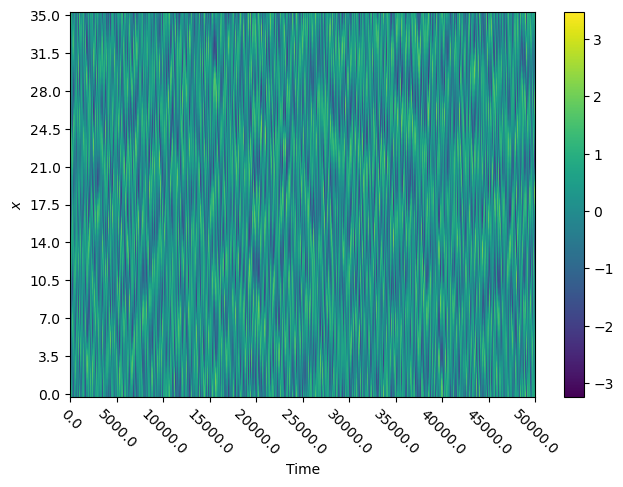

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50, 70])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [5e-5],
        [5e-5],
        [1e-5],
        [1e-6],
        [5e-7],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [30],
        [30],
        [30],
        [50],
        [50],
    ] # parameter for early stopping
    min_delta = 1e-5  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_rnn_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.0047 - mse: 3.1304e-04 - NMSE: 0.0028 - covmat_fro_loss: 2.1511e-04 - global_gradnorm: 0.3145 - tot_time: 0h 0m 26.6s

Epoch 1: val_NMSE improved from inf to 0.00251, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/check

Epoch 11/1000
76/76 [==============================] - ETA: 0s - loss: 0.0037 - mse: 2.0475e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7770e-04 - global_gradnorm: 0.1980 - tot_time: 0h 1m 59.7s

Epoch 11: val_NMSE improved from 0.00207 to 0.00207, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 125ms/step - loss: 0.0037 - mse: 2.0475e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7783e-04 - global_gradnorm: 0.1980 - val_loss: 0.0039 - val_mse: 2.2958e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
76/76 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.1820e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8262e-04 - global_gradnorm: 0.2253 - tot_time: 0h 2m 9.2s

Epoch 12: 

Epoch 22/1000
76/76 [==============================] - ETA: 0s - loss: 0.0035 - mse: 1.9144e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7199e-04 - global_gradnorm: 0.1968 - tot_time: 0h 3m 42.0s

Epoch 22: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 117ms/step - loss: 0.0035 - mse: 1.9144e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7189e-04 - global_gradnorm: 0.1966 - val_loss: 0.0037 - val_mse: 2.1262e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 23/1000
76/76 [==============================] - ETA: 0s - loss: 0.0035 - mse: 1.8892e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7134e-04 - global_gradnorm: 0.1912 - tot_time: 0h 3m 51.1s

Epoch 23: val_NMSE did not improve from 0.00186
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 34/1000
76/76 [==============================] - ETA: 0s - loss: 0.0033 - mse: 1.7993e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6726e-04 - global_gradnorm: 0.1786 - tot_time: 0h 5m 32.7s

Epoch 34: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 121ms/step - loss: 0.0033 - mse: 1.7993e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6720e-04 - global_gradnorm: 0.1781 - val_loss: 0.0035 - val_mse: 2.0377e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 35/1000
76/76 [==============================] - ETA: 0s - loss: 0.0033 - mse: 1.7783e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6645e-04 - global_gradnorm: 0.1811 - tot_time: 0h 5m 41.7s

Epoch 35: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 46/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.6458e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6051e-04 - global_gradnorm: 0.1599 - tot_time: 0h 7m 22.2s

Epoch 46: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 118ms/step - loss: 0.0031 - mse: 1.6458e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6053e-04 - global_gradnorm: 0.1595 - val_loss: 0.0034 - val_mse: 2.0696e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 47/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 1.6652e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6143e-04 - global_gradnorm: 0.1594 - tot_time: 0h 7m 31.4s

Epoch 47: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 58/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.5412e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5559e-04 - global_gradnorm: 0.1449 - tot_time: 0h 9m 13.6s

Epoch 58: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 121ms/step - loss: 0.0029 - mse: 1.5412e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5557e-04 - global_gradnorm: 0.1447 - val_loss: 0.0032 - val_mse: 1.8481e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 59/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.5591e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5653e-04 - global_gradnorm: 0.1558 - tot_time: 0h 9m 22.6s

Epoch 59: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 1.4763e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5271e-04 - global_gradnorm: 0.1394 - tot_time: 0h 11m 1.8s

Epoch 70: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 120ms/step - loss: 0.0028 - mse: 1.4763e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5276e-04 - global_gradnorm: 0.1394 - val_loss: 0.0032 - val_mse: 1.9579e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 71/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 1.5645e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5690e-04 - global_gradnorm: 0.1550 - tot_time: 0h 11m 10.8s

Epoch 71: val_NMSE did not improve from 0.00162
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/c

Epoch 82/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.4804e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5269e-04 - global_gradnorm: 0.1446 - tot_time: 0h 12m 50.1s

Epoch 82: val_NMSE improved from 0.00155 to 0.00154, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 126ms/step - loss: 0.0027 - mse: 1.4804e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5274e-04 - global_gradnorm: 0.1442 - val_loss: 0.0029 - val_mse: 1.7094e-04 - val_NMSE: 0.0015 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 83/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.5042e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5399e-04 - global_gradnorm: 0.1495 - tot_time: 0h 12m 59.7s

Epoch 

Epoch 94/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.4536e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5136e-04 - global_gradnorm: 0.1457 - tot_time: 0h 14m 38.9s

Epoch 94: val_NMSE did not improve from 0.00154
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 118ms/step - loss: 0.0027 - mse: 1.4536e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5127e-04 - global_gradnorm: 0.1456 - val_loss: 0.0030 - val_mse: 1.8832e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 95/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 1.4516e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5158e-04 - global_gradnorm: 0.1446 - tot_time: 0h 14m 47.9s

Epoch 95: val_NMSE improved from 0.00154 to 0.00153, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_r

Epoch 106/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 1.4040e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4912e-04 - global_gradnorm: 0.1330 - tot_time: 0h 16m 27.6s

Epoch 106: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 119ms/step - loss: 0.0026 - mse: 1.4040e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4915e-04 - global_gradnorm: 0.1332 - val_loss: 0.0029 - val_mse: 1.7571e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 107/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 1.3923e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.4832e-04 - global_gradnorm: 0.1359 - tot_time: 0h 16m 36.6s

Epoch 107: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

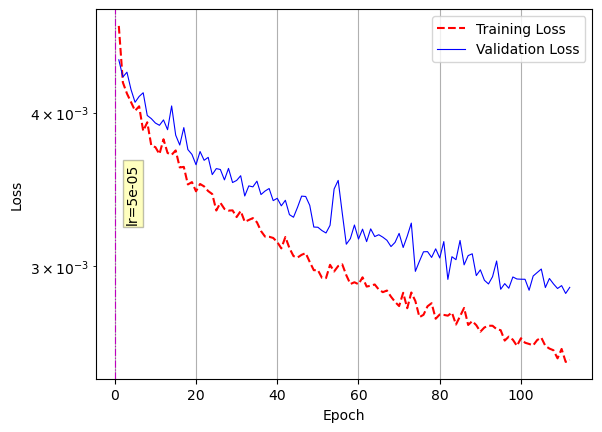

<Figure size 640x480 with 0 Axes>

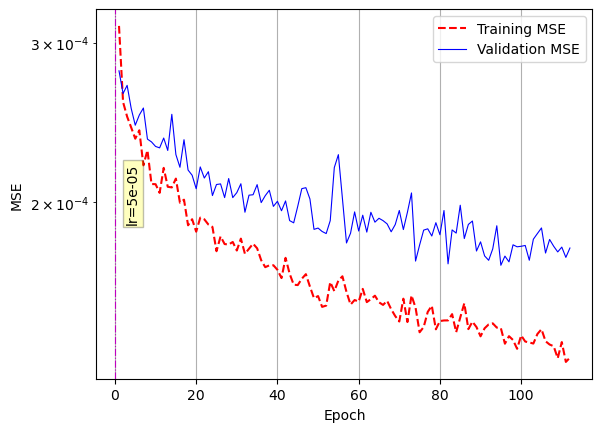

<Figure size 640x480 with 0 Axes>

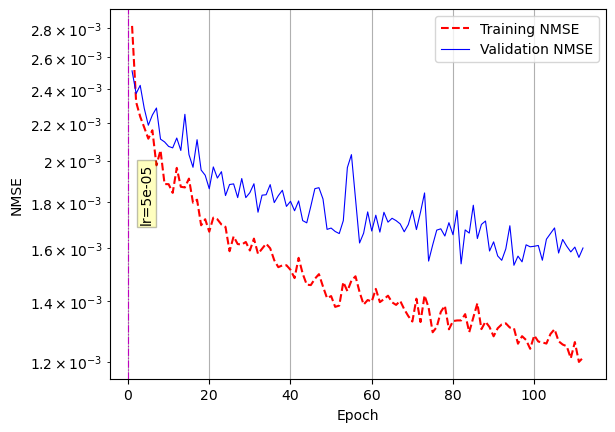

<Figure size 640x480 with 0 Axes>

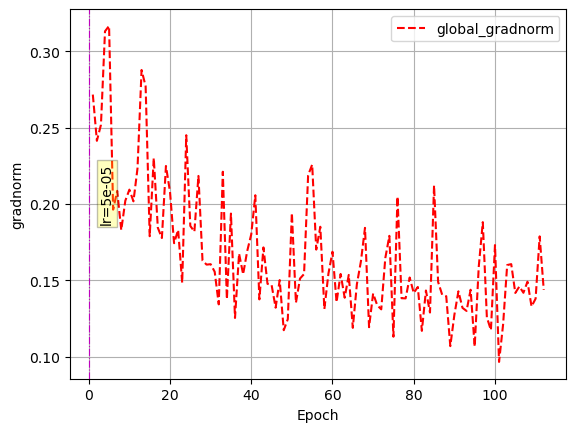



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.2533555507659912


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.6806e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.7142e-04 - global_gradnorm: 0.2534 - tot_time: 0h 0m 41.5s

Epoch 1: val_NMSE improved from inf to 0.00359, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 12/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 3.3283e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0441e-04 - global_gradnorm: 0.2534 - tot_time: 0h 2m 40.9s

Epoch 12: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 157ms/step - loss: 0.0041 - mse: 3.3283e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0412e-04 - global_gradnorm: 0.2534 - val_loss: 0.0043 - val_mse: 3.5587e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.1523e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9349e-04 - global_gradnorm: 0.2529 - tot_time: 0h 2m 51.5s

Epoch 13: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.9151e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7927e-04 - global_gradnorm: 0.2528 - tot_time: 0h 4m 48.1s

Epoch 24: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 148ms/step - loss: 0.0038 - mse: 2.9151e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7960e-04 - global_gradnorm: 0.2528 - val_loss: 0.0042 - val_mse: 3.5053e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 2.9755e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8370e-04 - global_gradnorm: 0.2527 - tot_time: 0h 4m 58.7s

Epoch 25: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/

Epoch 36/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.6598e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6361e-04 - global_gradnorm: 0.2527 - tot_time: 0h 6m 57.7s

Epoch 36: val_NMSE did not improve from 0.00289
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 150ms/step - loss: 0.0035 - mse: 2.6598e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6390e-04 - global_gradnorm: 0.2527 - val_loss: 0.0040 - val_mse: 3.2149e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 2.6838e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6410e-04 - global_gradnorm: 0.2523 - tot_time: 0h 7m 8.3s

Epoch 37: val_NMSE did not improve from 0.00289
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rn

Epoch 48/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 2.4923e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.5130e-04 - global_gradnorm: 0.2484 - tot_time: 0h 9m 6.1s

Epoch 48: val_NMSE did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 150ms/step - loss: 0.0034 - mse: 2.4923e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.5145e-04 - global_gradnorm: 0.2485 - val_loss: 0.0040 - val_mse: 3.2064e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 2.6486e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6283e-04 - global_gradnorm: 0.2523 - tot_time: 0h 9m 16.6s

Epoch 49: val_NMSE did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rn

Epoch 60/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.4444e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4966e-04 - global_gradnorm: 0.2483 - tot_time: 0h 11m 14.4s

Epoch 60: val_NMSE improved from 0.00271 to 0.00270, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 158ms/step - loss: 0.0033 - mse: 2.4444e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4992e-04 - global_gradnorm: 0.2484 - val_loss: 0.0038 - val_mse: 3.0052e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.4447e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.4952e-04 - global_gradnorm: 0.2490 - tot_time: 0h 11m 25.7s

Epoc

Epoch 72/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 2.3342e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4123e-04 - global_gradnorm: 0.2459 - tot_time: 0h 13m 23.0s

Epoch 72: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 150ms/step - loss: 0.0032 - mse: 2.3342e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4124e-04 - global_gradnorm: 0.2460 - val_loss: 0.0040 - val_mse: 3.2513e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 73/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 2.3644e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4377e-04 - global_gradnorm: 0.2430 - tot_time: 0h 13m 33.5s

Epoch 73: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 2.3370e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4174e-04 - global_gradnorm: 0.2419 - tot_time: 0h 15m 30.1s

Epoch 84: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 150ms/step - loss: 0.0032 - mse: 2.3370e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.4166e-04 - global_gradnorm: 0.2420 - val_loss: 0.0038 - val_mse: 3.0988e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 85/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 2.2737e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3715e-04 - global_gradnorm: 0.2421 - tot_time: 0h 15m 40.7s

Epoch 85: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_03

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 2.2383e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3495e-04 - global_gradnorm: 0.2424 - tot_time: 0h 17m 37.4s

Epoch 96: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 149ms/step - loss: 0.0031 - mse: 2.2383e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3552e-04 - global_gradnorm: 0.2426 - val_loss: 0.0040 - val_mse: 3.2631e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 97/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 2.2222e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.3366e-04 - global_gradnorm: 0.2458 - tot_time: 0h 17m 47.9s

Epoch 97: val_NMSE did not improve from 0.00246
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_03

<Figure size 640x480 with 0 Axes>

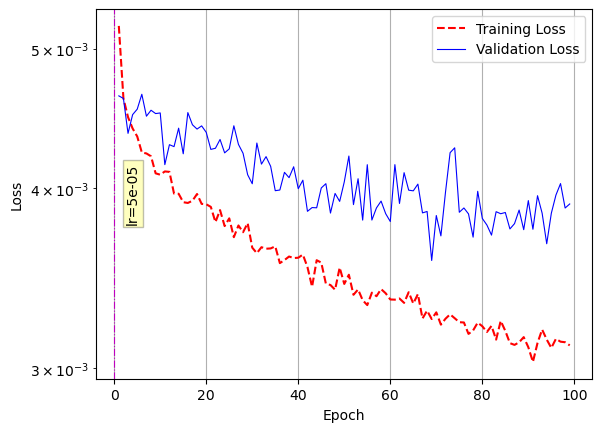

<Figure size 640x480 with 0 Axes>

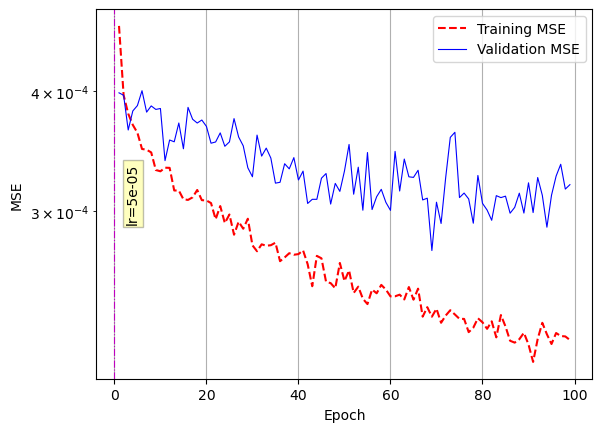

<Figure size 640x480 with 0 Axes>

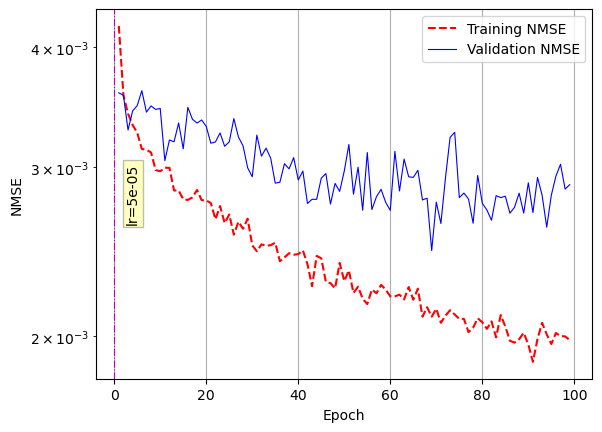

<Figure size 640x480 with 0 Axes>

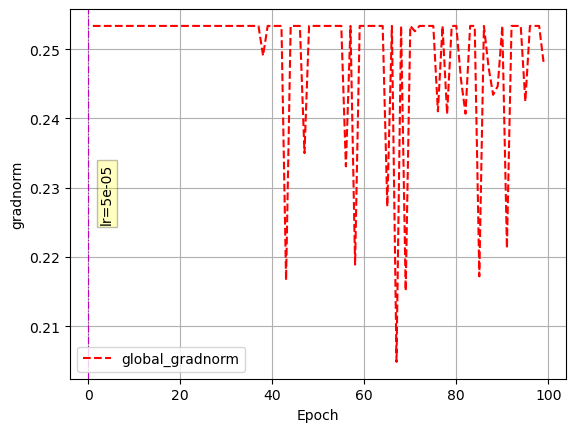



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.20268449783325196


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0078 - mse: 0.0011 - NMSE: 0.0098 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.2027 - tot_time: 0h 1m 49.1s

Epoch 1: val_NMSE improved from inf to 0.00902, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 12/1000
58/58 [==============================] - ETA: 0s - loss: 0.0059 - mse: 7.6352e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2027 - tot_time: 0h 5m 3.0s

Epoch 12: val_NMSE did not improve from 0.00815
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 301ms/step - loss: 0.0059 - mse: 7.6352e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2027 - val_loss: 0.0070 - val_mse: 9.5384e-04 - val_NMSE: 0.0086 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
58/58 [==============================] - ETA: 0s - loss: 0.0058 - mse: 7.3404e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2027 - tot_time: 0h 5m 20.3s

Epoch 13: val_NMSE did not improve from 0.00815
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034

Epoch 24/1000
58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 6.7372e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2027 - tot_time: 0h 8m 33.1s

Epoch 24: val_NMSE did not improve from 0.00798
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 302ms/step - loss: 0.0054 - mse: 6.7372e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2027 - val_loss: 0.0071 - val_mse: 9.6217e-04 - val_NMSE: 0.0087 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 6.6670e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2027 - tot_time: 0h 8m 50.5s

Epoch 25: val_NMSE improved from 0.00798 to 0.00795, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/check

Epoch 36/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 6.2110e-04 - NMSE: 0.0056 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2027 - tot_time: 0h 12m 4.6s

Epoch 36: val_NMSE did not improve from 0.00764
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 304ms/step - loss: 0.0051 - mse: 6.2110e-04 - NMSE: 0.0056 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2027 - val_loss: 0.0071 - val_mse: 9.5526e-04 - val_NMSE: 0.0086 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
58/58 [==============================] - ETA: 0s - loss: 0.0050 - mse: 6.0877e-04 - NMSE: 0.0055 - covmat_fro_loss: 9.9675e-04 - global_gradnorm: 0.2027 - tot_time: 0h 12m 22.1s

Epoch 37: val_NMSE did not improve from 0.00764
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_r

58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 5.8701e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.8128e-04 - global_gradnorm: 0.2027 - tot_time: 0h 15m 33.9s

Epoch 48: val_NMSE did not improve from 0.00764
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 299ms/step - loss: 0.0049 - mse: 5.8701e-04 - NMSE: 0.0053 - covmat_fro_loss: 9.8324e-04 - global_gradnorm: 0.2027 - val_loss: 0.0065 - val_mse: 8.5513e-04 - val_NMSE: 0.0077 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 5.7801e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.7451e-04 - global_gradnorm: 0.2027 - tot_time: 0h 15m 51.4s

Epoch 49: val_NMSE did not improve from 0.00764
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_03

Epoch 60/1000
58/58 [==============================] - ETA: 0s - loss: 0.0047 - mse: 5.4980e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.5195e-04 - global_gradnorm: 0.2027 - tot_time: 0h 19m 4.4s

Epoch 60: val_NMSE improved from 0.00760 to 0.00757, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 309ms/step - loss: 0.0047 - mse: 5.4980e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.5255e-04 - global_gradnorm: 0.2027 - val_loss: 0.0064 - val_mse: 8.4110e-04 - val_NMSE: 0.0076 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
58/58 [==============================] - ETA: 0s - loss: 0.0047 - mse: 5.5112e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.5661e-04 - global_gradnorm: 0.2027 - tot_time: 0h 19m 22.4s

Epoch

Epoch 72/1000
58/58 [==============================] - ETA: 0s - loss: 0.0047 - mse: 5.4455e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.4872e-04 - global_gradnorm: 0.2027 - tot_time: 0h 22m 34.8s

Epoch 72: val_NMSE did not improve from 0.00757
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 302ms/step - loss: 0.0047 - mse: 5.4455e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.5087e-04 - global_gradnorm: 0.2027 - val_loss: 0.0069 - val_mse: 9.2878e-04 - val_NMSE: 0.0084 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 73/1000
58/58 [==============================] - ETA: 0s - loss: 0.0046 - mse: 5.2405e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.3000e-04 - global_gradnorm: 0.2027 - tot_time: 0h 22m 52.3s

Epoch 73: val_NMSE did not improve from 0.00757
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 84/1000
58/58 [==============================] - ETA: 0s - loss: 0.0045 - mse: 5.1340e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.2302e-04 - global_gradnorm: 0.2027 - tot_time: 0h 26m 5.7s

Epoch 84: val_NMSE did not improve from 0.00735
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 301ms/step - loss: 0.0045 - mse: 5.1340e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.2272e-04 - global_gradnorm: 0.2027 - val_loss: 0.0064 - val_mse: 8.4483e-04 - val_NMSE: 0.0076 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 85/1000
58/58 [==============================] - ETA: 0s - loss: 0.0044 - mse: 5.0170e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.1214e-04 - global_gradnorm: 0.2027 - tot_time: 0h 26m 23.1s

Epoch 85: val_NMSE did not improve from 0.00735
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

58/58 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.9337e-04 - NMSE: 0.0044 - covmat_fro_loss: 9.0457e-04 - global_gradnorm: 0.2027 - tot_time: 0h 29m 34.6s

Epoch 96: val_NMSE did not improve from 0.00735
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 299ms/step - loss: 0.0044 - mse: 4.9337e-04 - NMSE: 0.0044 - covmat_fro_loss: 9.0450e-04 - global_gradnorm: 0.2027 - val_loss: 0.0064 - val_mse: 8.4531e-04 - val_NMSE: 0.0076 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 97/1000
58/58 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.9665e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.0949e-04 - global_gradnorm: 0.2027 - tot_time: 0h 29m 52.2s

Epoch 97: val_NMSE did not improve from 0.00735
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_03

Epoch 108/1000
58/58 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.8034e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9398e-04 - global_gradnorm: 0.2027 - tot_time: 0h 33m 4.9s

Epoch 108: val_NMSE did not improve from 0.00713
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 304ms/step - loss: 0.0043 - mse: 4.8034e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9418e-04 - global_gradnorm: 0.2027 - val_loss: 0.0061 - val_mse: 7.9586e-04 - val_NMSE: 0.0072 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 109/1000
58/58 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.7822e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.9659e-04 - global_gradnorm: 0.2027 - tot_time: 0h 33m 22.4s

Epoch 109: val_NMSE did not improve from 0.00713
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

58/58 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.7270e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.8917e-04 - global_gradnorm: 0.2027 - tot_time: 0h 36m 34.9s

Epoch 120: val_NMSE did not improve from 0.00713
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 303ms/step - loss: 0.0043 - mse: 4.7270e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.8906e-04 - global_gradnorm: 0.2027 - val_loss: 0.0064 - val_mse: 8.4398e-04 - val_NMSE: 0.0076 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 121/1000
58/58 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.6692e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.8171e-04 - global_gradnorm: 0.2027 - tot_time: 0h 36m 52.3s

Epoch 121: val_NMSE did not improve from 0.00713
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 132/1000
58/58 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.5855e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7658e-04 - global_gradnorm: 0.2027 - tot_time: 0h 40m 6.3s

Epoch 132: val_NMSE did not improve from 0.00689
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 304ms/step - loss: 0.0042 - mse: 4.5855e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7812e-04 - global_gradnorm: 0.2027 - val_loss: 0.0062 - val_mse: 8.1341e-04 - val_NMSE: 0.0073 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 133/1000
58/58 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.5970e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7819e-04 - global_gradnorm: 0.2027 - tot_time: 0h 40m 23.6s

Epoch 133: val_NMSE did not improve from 0.00689
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

58/58 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.5467e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7169e-04 - global_gradnorm: 0.2027 - tot_time: 0h 43m 36.0s

Epoch 144: val_NMSE did not improve from 0.00689
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 303ms/step - loss: 0.0042 - mse: 4.5467e-04 - NMSE: 0.0041 - covmat_fro_loss: 8.7227e-04 - global_gradnorm: 0.2027 - val_loss: 0.0065 - val_mse: 8.6224e-04 - val_NMSE: 0.0078 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 145/1000
58/58 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.4415e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.6426e-04 - global_gradnorm: 0.2027 - tot_time: 0h 43m 53.6s

Epoch 145: val_NMSE did not improve from 0.00689
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

58/58 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.3606e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.5460e-04 - global_gradnorm: 0.2027 - tot_time: 0h 47m 7.7s

Epoch 156: val_NMSE did not improve from 0.00689
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 313ms/step - loss: 0.0040 - mse: 4.3606e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.5510e-04 - global_gradnorm: 0.2027 - val_loss: 0.0063 - val_mse: 8.2015e-04 - val_NMSE: 0.0074 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 157/1000
58/58 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.3419e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.5373e-04 - global_gradnorm: 0.2027 - tot_time: 0h 47m 25.3s

Epoch 157: val_NMSE did not improve from 0.00689
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

<Figure size 640x480 with 0 Axes>

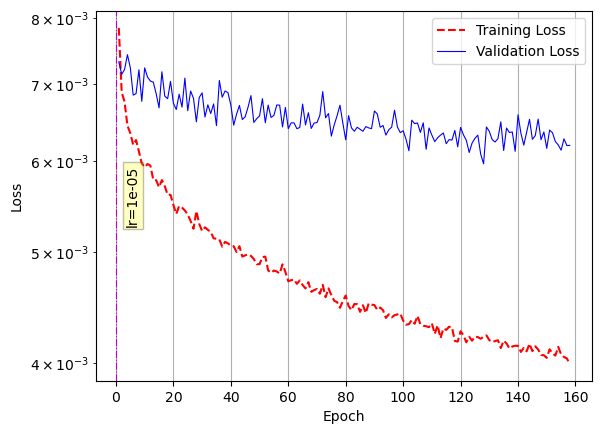

<Figure size 640x480 with 0 Axes>

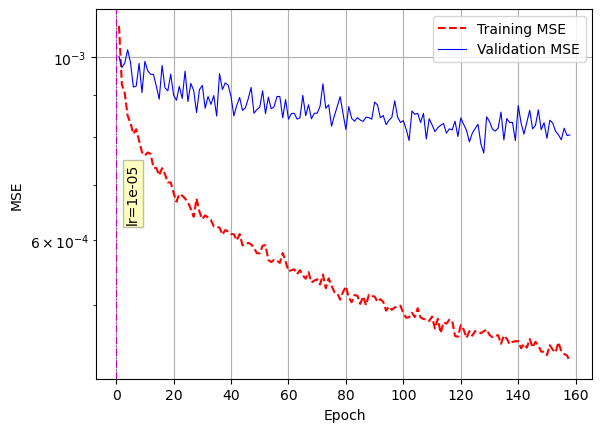

<Figure size 640x480 with 0 Axes>

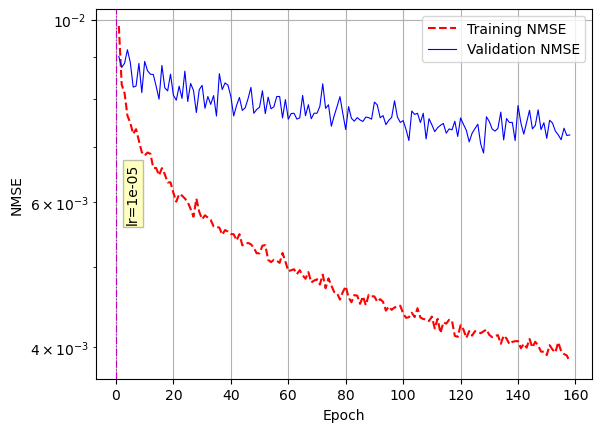

<Figure size 640x480 with 0 Axes>

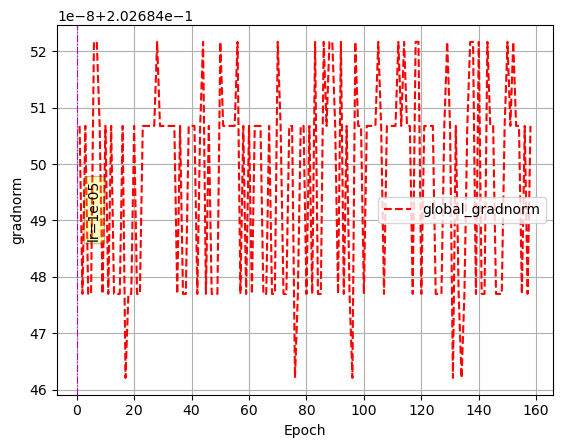



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.1621476173400879


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
49/49 [==============================] - ETA: 0s - loss: 0.0097 - mse: 0.0019 - NMSE: 0.0173 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.1621 - tot_time: 0h 3m 19.6s

Epoch 1: val_NMSE improved from inf to 0.02313, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_03

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 25s 516ms/step - loss: 0.0083 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.1621 - val_loss: 0.0121 - val_mse: 0.0025 - val_NMSE: 0.0222 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
49/49 [==============================] - ETA: 0s - loss: 0.0083 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.1621 - tot_time: 0h 8m 3.4s

Epoch 12: val_NMSE did not improve from 0.02200
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 26s 525ms/step - loss: 0.0083 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.1621 - val_loss: 0.0121 - val_mse: 0.0025 - val_NMSE

49/49 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0015 - NMSE: 0.0132 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.1621 - tot_time: 0h 12m 42.3s

Epoch 23: val_NMSE did not improve from 0.02136
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 25s 515ms/step - loss: 0.0079 - mse: 0.0015 - NMSE: 0.0132 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.1621 - val_loss: 0.0120 - val_mse: 0.0024 - val_NMSE: 0.0220 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
49/49 [==============================] - ETA: 0s - loss: 0.0078 - mse: 0.0014 - NMSE: 0.0130 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.1621 - tot_time: 0h 13m 7.1s

Epoch 24: val_NMSE did not improve from 0.02136
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCh

49/49 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.1621 - tot_time: 0h 17m 42.7s

Epoch 35: val_NMSE did not improve from 0.02117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 25s 520ms/step - loss: 0.0075 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.1621 - val_loss: 0.0119 - val_mse: 0.0024 - val_NMSE: 0.0217 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
49/49 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.1621 - tot_time: 0h 18m 8.2s

Epoch 36: val_NMSE improved from 0.02117 to 0.02114, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-50_outsteps

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 578ms/step - loss: 0.0073 - mse: 0.0013 - NMSE: 0.0119 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - val_loss: 0.0118 - val_mse: 0.0024 - val_NMSE: 0.0216 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
49/49 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0013 - NMSE: 0.0118 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - tot_time: 0h 23m 42.3s

Epoch 48: val_NMSE improved from 0.02114 to 0.02090, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 581ms/step - loss: 0.0072

Epoch 60/1000
49/49 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0013 - NMSE: 0.0115 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - tot_time: 0h 29m 18.1s

Epoch 60: val_NMSE did not improve from 0.02090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 573ms/step - loss: 0.0071 - mse: 0.0013 - NMSE: 0.0115 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - val_loss: 0.0118 - val_mse: 0.0024 - val_NMSE: 0.0217 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
49/49 [==============================] - ETA: 0s - loss: 0.0070 - mse: 0.0013 - NMSE: 0.0114 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - tot_time: 0h 29m 46.4s

Epoch 61: val_NMSE did not improve from 0.02090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 568ms/step - loss: 0.0069 - mse: 0.0012 - NMSE: 0.0110 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - val_loss: 0.0116 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 73/1000
49/49 [==============================] - ETA: 0s - loss: 0.0070 - mse: 0.0013 - NMSE: 0.0113 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - tot_time: 0h 35m 22.6s

Epoch 73: val_NMSE did not improve from 0.02080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 566ms/step - loss: 0.0070 - mse: 0.0013 - NMSE: 0.0113 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - val_loss: 0.0116 - val_mse: 0.0023 - val_NM

Epoch 85/1000
49/49 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0012 - NMSE: 0.0109 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - tot_time: 0h 40m 59.6s

Epoch 85: val_NMSE did not improve from 0.02073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 574ms/step - loss: 0.0068 - mse: 0.0012 - NMSE: 0.0109 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - val_loss: 0.0116 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 86/1000
49/49 [==============================] - ETA: 0s - loss: 0.0069 - mse: 0.0012 - NMSE: 0.0110 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - tot_time: 0h 41m 27.7s

Epoch 86: val_NMSE did not improve from 0.02073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/

Epoch 98/1000
49/49 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0012 - NMSE: 0.0106 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - tot_time: 0h 47m 4.9s

Epoch 98: val_NMSE did not improve from 0.02073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 579ms/step - loss: 0.0067 - mse: 0.0012 - NMSE: 0.0106 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - val_loss: 0.0115 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 99/1000
49/49 [==============================] - ETA: 0s - loss: 0.0067 - mse: 0.0012 - NMSE: 0.0107 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - tot_time: 0h 47m 32.9s

Epoch 99: val_NMSE did not improve from 0.02073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/L

Epoch 111/1000
49/49 [==============================] - ETA: 0s - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0103 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - tot_time: 0h 53m 10.5s

Epoch 111: val_NMSE did not improve from 0.02073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 573ms/step - loss: 0.0066 - mse: 0.0011 - NMSE: 0.0103 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - val_loss: 0.0117 - val_mse: 0.0024 - val_NMSE: 0.0213 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 112/1000
49/49 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0011 - NMSE: 0.0102 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.1621 - tot_time: 0h 53m 38.7s

Epoch 112: val_NMSE did not improve from 0.02073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoi

49/49 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 0h 58m 52.6s

Epoch 123: val_NMSE did not improve from 0.02055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 29s 586ms/step - loss: 0.0065 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0115 - val_mse: 0.0023 - val_NMSE: 0.0209 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 124/1000
49/49 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0011 - NMSE: 0.0102 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 0h 59m 21.3s

Epoch 124: val_NMSE did not improve from 0.02055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistori

Epoch 136/1000
49/49 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 4m 59.2s

Epoch 136: val_NMSE improved from 0.02055 to 0.02053, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 29s 589ms/step - loss: 0.0064 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0113 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 137/1000
49/49 [==============================] - ETA: 0s - loss: 0.0064 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 5m 28.3s

Epoch 137: val_NMSE did not imp

49/49 [==============================] - ETA: 0s - loss: 0.0063 - mse: 0.0011 - NMSE: 0.0098 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 10m 39.4s

Epoch 148: val_NMSE did not improve from 0.02049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 576ms/step - loss: 0.0063 - mse: 0.0011 - NMSE: 0.0098 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0114 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 149/1000
49/49 [==============================] - ETA: 0s - loss: 0.0063 - mse: 0.0011 - NMSE: 0.0098 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 11m 7.2s

Epoch 149: val_NMSE did not improve from 0.02049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistorie

Epoch 161/1000
49/49 [==============================] - ETA: 0s - loss: 0.0062 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 16m 48.7s

Epoch 161: val_NMSE did not improve from 0.02049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 578ms/step - loss: 0.0062 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0113 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 162/1000
49/49 [==============================] - ETA: 0s - loss: 0.0062 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 17m 17.6s

Epoch 162: val_NMSE did not improve from 0.02049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 26s 537ms/step - loss: 0.0062 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0116 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 174/1000
49/49 [==============================] - ETA: 0s - loss: 0.0062 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 22m 56.6s

Epoch 174: val_NMSE did not improve from 0.02045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 573ms/step - loss: 0.0062 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0114 - val_mse: 0.0023 - val_

Epoch 186/1000
49/49 [==============================] - ETA: 0s - loss: 0.0061 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 28m 33.3s

Epoch 186: val_NMSE did not improve from 0.02045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 575ms/step - loss: 0.0061 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0115 - val_mse: 0.0023 - val_NMSE: 0.0209 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 187/1000
49/49 [==============================] - ETA: 0s - loss: 0.0061 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 29m 0.9s

Epoch 187: val_NMSE did not improve from 0.02045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoin

49/49 [==============================] - ETA: 0s - loss: 0.0060 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 33m 56.7s

Epoch 198: val_NMSE did not improve from 0.02040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 26s 539ms/step - loss: 0.0060 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0113 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 199/1000
49/49 [==============================] - ETA: 0s - loss: 0.0060 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 34m 22.4s

Epoch 199: val_NMSE did not improve from 0.02040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 26s 537ms/step - loss: 0.0060 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0116 - val_mse: 0.0024 - val_NMSE: 0.0212 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 211/1000
49/49 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.9787e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 39m 37.7s

Epoch 211: val_NMSE did not improve from 0.02029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 26s 533ms/step - loss: 0.0059 - mse: 9.9787e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0115 - val_mse: 0.002

Epoch 223/1000
49/49 [==============================] - ETA: 0s - loss: 0.0060 - mse: 0.0010 - NMSE: 0.0090 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621   - tot_time: 1h 44m 59.1s

Epoch 223: val_NMSE did not improve from 0.02029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 567ms/step - loss: 0.0060 - mse: 0.0010 - NMSE: 0.0090 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0114 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 224/1000
49/49 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.8573e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 45m 26.6s

Epoch 224: val_NMSE did not improve from 0.02029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/ch

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 573ms/step - loss: 0.0059 - mse: 9.9812e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0115 - val_mse: 0.0023 - val_NMSE: 0.0209 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 236/1000
49/49 [==============================] - ETA: 0s - loss: 0.0059 - mse: 9.8314e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 51m 0.8s

Epoch 236: val_NMSE did not improve from 0.02029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 564ms/step - loss: 0.0059 - mse: 9.8314e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0115 - val_mse: 0.

Epoch 248/1000
49/49 [==============================] - ETA: 0s - loss: 0.0058 - mse: 9.7634e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 56m 37.7s

Epoch 248: val_NMSE did not improve from 0.02029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 28s 577ms/step - loss: 0.0058 - mse: 9.7634e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - val_loss: 0.0113 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 249/1000
49/49 [==============================] - ETA: 0s - loss: 0.0058 - mse: 9.5859e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.1621 - tot_time: 1h 57m 5.7s

Epoch 249: val_NMSE did not improve from 0.02029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

<Figure size 640x480 with 0 Axes>

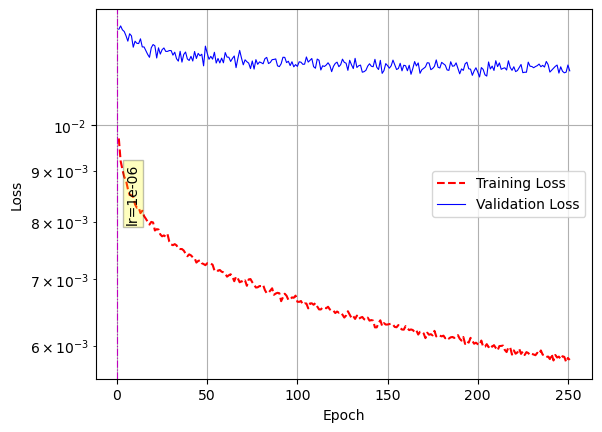

<Figure size 640x480 with 0 Axes>

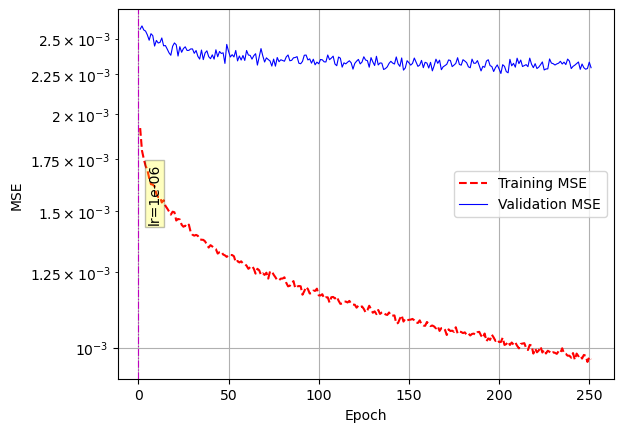

<Figure size 640x480 with 0 Axes>

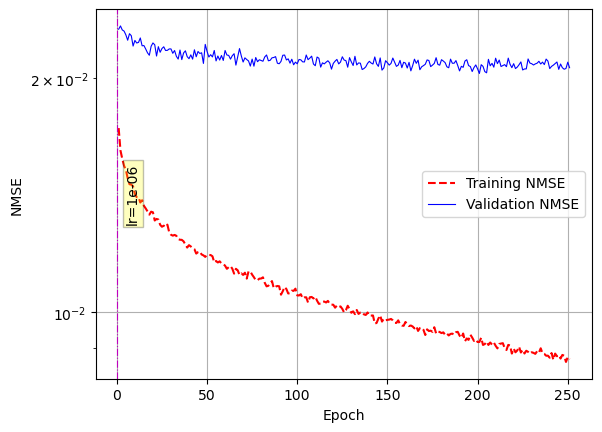

<Figure size 640x480 with 0 Axes>

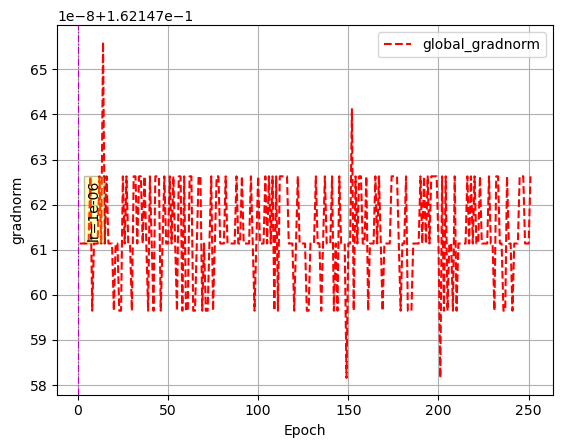



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 70 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.1297181248664856


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-07 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
42/42 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0044 - NMSE: 0.0400 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1297 - tot_time: 0h 4m 8.8s

Epoch 1: val_NMSE improved from inf to 0.05527, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-70_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034

Epoch 11/1000
42/42 [==============================] - ETA: 0s - loss: 0.0127 - mse: 0.0036 - NMSE: 0.0321 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1297 - tot_time: 0h 9m 32.4s

Epoch 11: val_NMSE did not improve from 0.05437
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 32s 769ms/step - loss: 0.0127 - mse: 0.0036 - NMSE: 0.0321 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1297 - val_loss: 0.0202 - val_mse: 0.0061 - val_NMSE: 0.0553 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
42/42 [==============================] - ETA: 0s - loss: 0.0125 - mse: 0.0035 - NMSE: 0.0315 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1297 - tot_time: 0h 10m 4.6s

Epoch 12: val_NMSE did not improve from 0.05437
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/Lo

42/42 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0032 - NMSE: 0.0290 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1297 - tot_time: 0h 16m 2.4s

Epoch 23: val_NMSE improved from 0.05382 to 0.05373, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/checkpoint-70_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 33s 789ms/step - loss: 0.0117 - mse: 0.0032 - NMSE: 0.0290 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1297 - val_loss: 0.0198 - val_mse: 0.0060 - val_NMSE: 0.0537 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
42/42 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0033 - NMSE: 0.0297 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1297 - tot_time: 0h 16m 35.4s

Epoch 24: val_NMSE did not improve from 0.05373

42/42 [==============================] - ETA: 0s - loss: 0.0111 - mse: 0.0030 - NMSE: 0.0271 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1297 - tot_time: 0h 22m 30.2s

Epoch 35: val_NMSE did not improve from 0.05316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 32s 770ms/step - loss: 0.0111 - mse: 0.0030 - NMSE: 0.0271 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1297 - val_loss: 0.0196 - val_mse: 0.0059 - val_NMSE: 0.0533 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
42/42 [==============================] - ETA: 0s - loss: 0.0112 - mse: 0.0030 - NMSE: 0.0274 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1297 - tot_time: 0h 23m 2.4s

Epoch 36: val_NMSE did not improve from 0.05316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCh

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 32s 756ms/step - loss: 0.0107 - mse: 0.0029 - NMSE: 0.0260 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297 - val_loss: 0.0199 - val_mse: 0.0060 - val_NMSE: 0.0543 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
42/42 [==============================] - ETA: 0s - loss: 0.0108 - mse: 0.0029 - NMSE: 0.0261 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1297 - tot_time: 0h 29m 28.6s

Epoch 48: val_NMSE did not improve from 0.05261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 32s 767ms/step - loss: 0.0108 - mse: 0.0029 - NMSE: 0.0261 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297 - val_loss: 0.0201 - val_mse: 0.0061 - val_NM

Epoch 60/1000
42/42 [==============================] - ETA: 0s - loss: 0.0105 - mse: 0.0028 - NMSE: 0.0251 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297 - tot_time: 0h 35m 54.9s

Epoch 60: val_NMSE did not improve from 0.05261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 32s 769ms/step - loss: 0.0105 - mse: 0.0028 - NMSE: 0.0251 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297 - val_loss: 0.0199 - val_mse: 0.0060 - val_NMSE: 0.0544 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
42/42 [==============================] - ETA: 0s - loss: 0.0104 - mse: 0.0028 - NMSE: 0.0248 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297 - tot_time: 0h 36m 27.1s

Epoch 61: val_NMSE did not improve from 0.05261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/

Epoch 73/1000
42/42 [==============================] - ETA: 0s - loss: 0.0102 - mse: 0.0027 - NMSE: 0.0244 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297 - tot_time: 0h 42m 54.1s

Epoch 73: val_NMSE did not improve from 0.05261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 32s 770ms/step - loss: 0.0102 - mse: 0.0027 - NMSE: 0.0244 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297 - val_loss: 0.0195 - val_mse: 0.0059 - val_NMSE: 0.0529 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 74/1000
42/42 [==============================] - ETA: 0s - loss: 0.0100 - mse: 0.0026 - NMSE: 0.0236 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297 - tot_time: 0h 43m 26.3s

Epoch 74: val_NMSE did not improve from 0.05261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/

Epoch 86/1000
42/42 [==============================] - ETA: 0s - loss: 0.0097 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297 - tot_time: 0h 49m 53.2s

Epoch 86: val_NMSE did not improve from 0.05261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_034/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 32s 766ms/step - loss: 0.0097 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297 - val_loss: 0.0195 - val_mse: 0.0059 - val_NMSE: 0.0527 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 87/1000
42/42 [==============================] - ETA: 0s - loss: 0.0098 - mse: 0.0026 - NMSE: 0.0231 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1297Restoring model weights from the end of the best epoch: 37.
 - tot_time: 0h 50m 25.4s

Epoch 87: val_NMSE did not improve from 0.05261
 - saving loss histories at /home/rkaushik/Document

<Figure size 640x480 with 0 Axes>

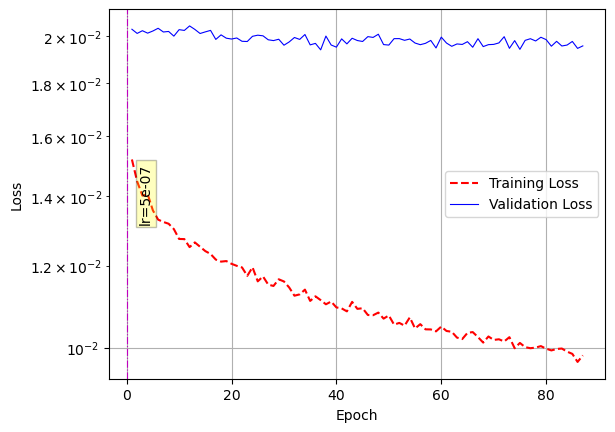

<Figure size 640x480 with 0 Axes>

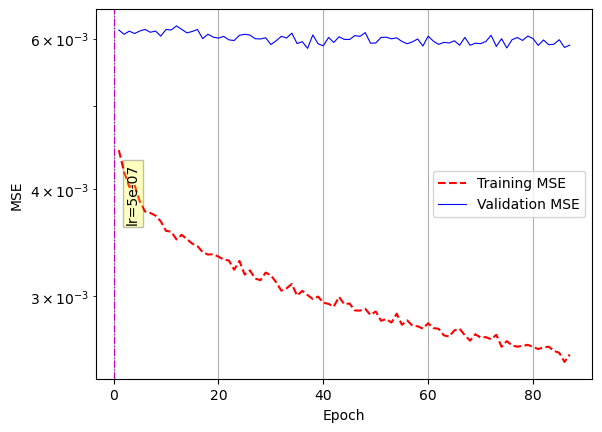

<Figure size 640x480 with 0 Axes>

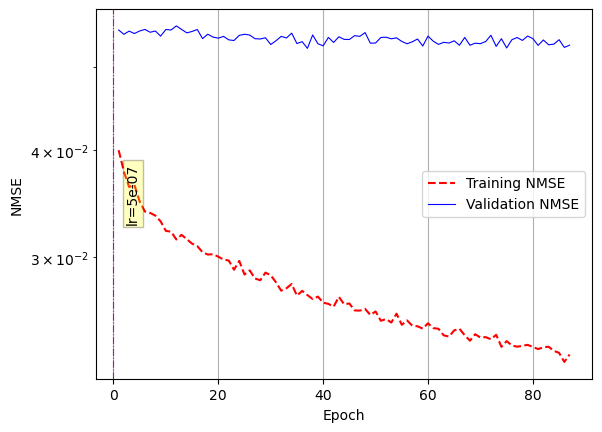

<Figure size 640x480 with 0 Axes>

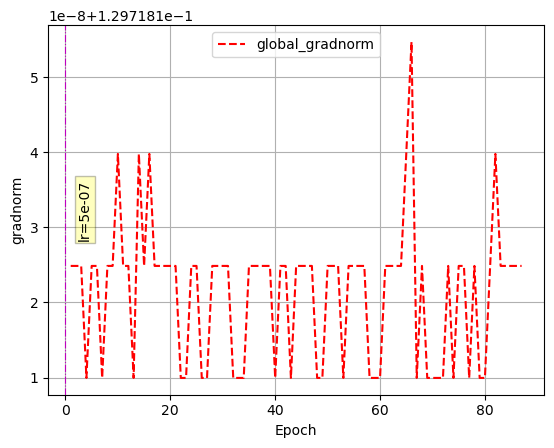

<Figure size 640x480 with 0 Axes>

In [21]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    grad_norm_decay = 0.8
    idxs_to_ignore = 0

    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    # global_clipnorm = 0.25 * np.round(4*global_clipnorm)
    global_clipnorm = grad_norm_decay * global_clipnorm

In [22]:
a = 123e-5
a

0.00123

In [23]:
s = '{:E}'.format(a)
s

'1.230000E-03'

In [24]:
idx = s.find('E')
num = float(s[0:idx])
10**float(s[idx+1:])

0.001

In [25]:
### Training the combined AE-RNN


# 